A user has suggested a new measure of topical preparations containing antimicrobial ([GitHub issue](https://github.com/ebmdatalab/openprescribing/issues/2481)). The [BNF states](https://bnf.nice.org.uk/drug/emollient-creams-and-ointments-antimicrobial-containing.html) that topical _Preparations containing an antibacterial should be avoided unless infection is present or is a frequent complication._

In this notebook we set out to examine use of topical antibacterials.

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [2]:
sql = '''
SELECT
    pct,
    CAST(month AS DATE) AS month,
    bnf_name,
    bnf_code,
    SUM(items) AS items,
    SUM(actual_cost) AS cost
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
INNER JOIN
  hscic.ccgs AS ccg
ON
  presc.pct=ccg.code
WHERE
    ccg.org_type='CCG' AND
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM ebmdatalab.measures.dmd_objs_with_form_route
        WHERE 
        (form_route LIKE '%cream%' OR
        form_route LIKE'%oint%' OR
        form_route LIKE'%cutaneous%'
        ) 
        AND
        (bnf_code LIKE '131001%' OR # Antibacterial Preps Only Used Topically
        bnf_code LIKE '131002%' OR  #Antifungal Preparations 
        bnf_name LIKE 'Oilatum Plus%' OR #contains benzalkonium
        bnf_name LIKE 'Dermol%' OR #contains benzalkonium
        bnf_name LIKE 'Emulsiderm%') #contains benzalkonium
        )
GROUP BY pct, month, bnf_name, bnf_code
ORDER BY pct, month
'''

df_top_abx = bq.cached_read(sql, csv_path='df_top_abx.csv')
df_top_abx['month'] = df_top_abx['month'].astype('datetime64[ns]')
df_top_abx.head()

,pct,month,bnf_name,bnf_code,items,cost
0,00C,2010-08-01,Lamisil AT_P/Spy 1% 15ml,131002030BBACAB,2,9.09
1,00C,2010-08-01,Mupirocin_Crm 2%,1310011M0AAABAB,5,20.28
2,00C,2010-08-01,Bactroban_Crm 2%,1310011M0BBABAB,2,12.12
3,00C,2010-08-01,Terbinafine HCl_Crm 1%,131002030AAAAAA,32,141.55
4,00C,2010-08-01,Dermol 600_Bath Emollient,130201100BBAQA0,23,167.49


(0, 566595.55)

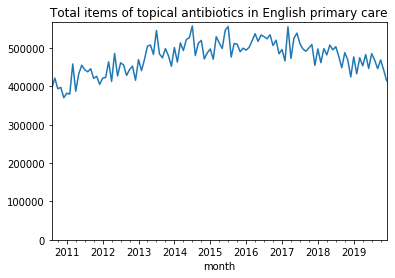

In [3]:

df_top_abx.groupby("month")['items'].sum().plot(kind='line', title="Total items of topical antibiotics in English primary care")
plt.ylim(0, )

In [4]:

df_top_abx.nunique()

pct            191
month          113
bnf_name       159
bnf_code       146
items         2311
cost        370649
dtype: int64

In [5]:
## this gives us a list of unique preparations
df_top_abx["bnf_name"].unique()

array(['Lamisil AT_P/Spy 1% 15ml', 'Mupirocin_Crm 2%', 'Bactroban_Crm 2%',
       'Terbinafine HCl_Crm 1%', 'Dermol 600_Bath Emollient',
       'Mupirocin_Oint 2%', 'Trosyl_Nail Soln 283mg/ml + Applic',
       'Canesten_Antifungal Crm 1%', 'Flamazine_Crm 1%', 'Acea_Gel 0.75%',
       'Canesten_Crm 1%', 'Nystatin/Chlorhex HCl_Crm 100 000u/1%',
       'Oilatum Plus_Bath Additive', 'Metrogel_Gel 0.75%',
       'Emulsiderm_Emollient', 'Lamisil_Crm 1%',
       'Metronidazole_Gel 0.75%', 'Dermol 500_Lot',
       'Loceryl_Nail Laquer Kit 5% 5ml', 'Terbinafine HCl_Spy 1% 15ml',
       'Nystaform_Crm', 'Fucidin_Oint 2%', 'Daktarin_Crm 2%',
       'Dermol_Crm', 'Ketoconazole_Crm 2%', 'Silver Sulfadiazine_Crm 1%',
       'Rozex_Crm 0.75%', 'Nizoral_Crm 2%', 'Clotrimazole_Crm 1%',
       'Sod Fusidate_Oint 2%', 'Clotrimazole_Soln 1%',
       'Miconazole Nit_Dust Pdr 2%', 'Phytex_Paint + Brush',
       'Amorolfine HCl_Nail Laquer Kit 5% 5ml', 'Polyfax_Oint',
       'Bactroban_Oint 2%', 'Canesten_So

In [6]:

##groupby bnf name + code  to see largest volume in terms of items
df_products = df_top_abx.groupby(['bnf_code', 'bnf_name']).sum().reset_index().sort_values(by = 'items', ascending = False)
df_products.head(11)

,bnf_code,bnf_name,items,cost
0,130201000BBICBW,Dermol 500_Lot,9757074,6.186569e+07
27,1310012F0AAABAB,Fusidic Acid_Crm 2%,8022112,1.885158e+07
83,1310020H0AAABAB,Clotrimazole_Crm 1%,7735654,1.406565e+07
1,130201000BBKFA0,Dermol_Crm,4210112,2.537483e+07
103,1310020N0AAAAAA,Miconazole Nit_Crm 2%,3344394,6.864498e+06
3,130201100BBAZAN,Dermol 200_Shower Emollient,2630810,1.379191e+07
51,131002030AAAAAA,Terbinafine HCl_Crm 1%,2090164,7.108716e+06
2,130201100BBAQA0,Dermol 600_Bath Emollient,2075332,1.629249e+07
5,1302011L0BEAAAD,Oilatum Plus_Bath Additive,1676461,1.251557e+07
62,1310020A0AAAAAA,Amorolfine HCl_Nail Lacquer Kit 5% 5ml,1344267,1.124345e+07


## Map and Charts

In [7]:
ccg_total_abx = df_top_abx.groupby(["month", "pct"])["items"].sum().reset_index()
ccg_total_abx.head(5)

,month,pct,items
0,2010-08-01,00C,677
1,2010-08-01,00D,2318
2,2010-08-01,00J,1898
3,2010-08-01,00K,1914
4,2010-08-01,00L,2100


In [8]:
df_list = pd.read_csv('listsize.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(5)

,month,pct,list_size
0,2015-01-01,NaN,0
1,2015-01-01,00C,106673
2,2015-01-01,00D,288824
3,2015-01-01,00F,207011
4,2015-01-01,00G,163290


In [9]:
top_abx_1000 = pd.merge(ccg_total_abx, df_list, on=['month', 'pct'])
top_abx_1000['top_abx_items_per_1000'] = 1000* (top_abx_1000['items']/top_abx_1000['list_size'])
top_abx_1000.head(5)

,month,pct,items,list_size,top_abx_items_per_1000
0,2015-01-01,00C,896,106673,8.399501
1,2015-01-01,00D,2848,288824,9.860676
2,2015-01-01,00J,2404,252951,9.503817
3,2015-01-01,00K,2448,293006,8.354778
4,2015-01-01,00L,2345,322094,7.280483


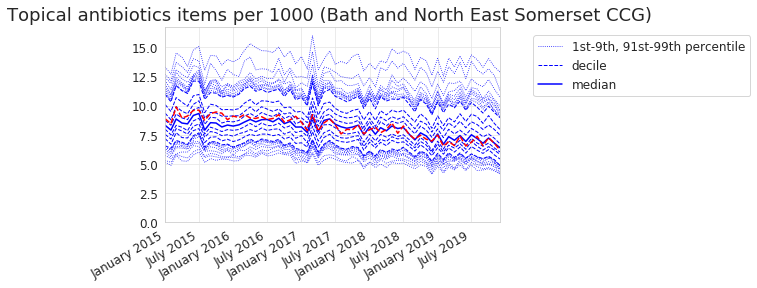

In [10]:
#create sample deciles & prototype measure
charts.deciles_chart(
        top_abx_1000,
        period_column='month',
        column='top_abx_items_per_1000',
        title="Topical antibiotics items per 1000 (Bath and North East Somerset CCG) ",
        show_outer_percentiles=True)

#add in example CCG (Islington)
df_subject = top_abx_1000.loc[top_abx_1000['pct'] == '11E']
plt.plot(df_subject['month'], df_subject['top_abx_items_per_1000'], 'r--')

plt.show()

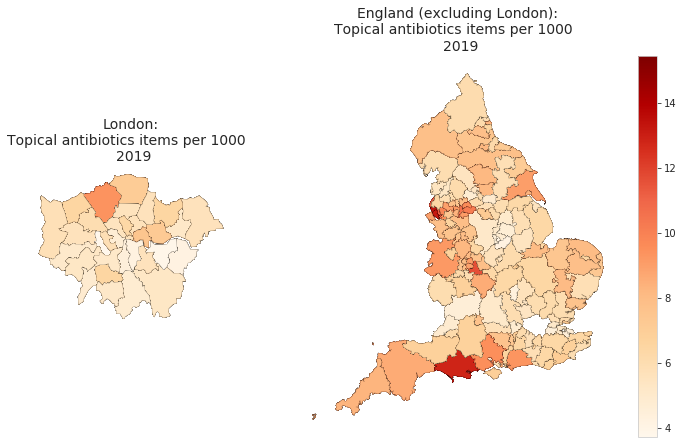

In [11]:
#create choropeth map of items per 1000 patients
plt.figure(figsize=(12, 7))
latest_top_abx_1000 = top_abx_1000.loc[(top_abx_1000['month'] >= '2019-01-01') & (top_abx_1000['month'] <= '2019-12-01')]
plt = maps.ccg_map(latest_top_abx_1000, title="Topical antibiotics items per 1000  \n  2019 ", column='top_abx_items_per_1000', separate_london=True)
plt.show()